### Understanding the time taken for customers to order their meals

In this code, we seek to estimate the duration taken for customers to order their food at the restaurant, which will be useful information for restaurateurs in planning their operations, capacity, and/or customer waiting time during busy periods.

To do so, we first process the video ('video_sample1') into per second image frames.

We then manually select a subset of the images and give labels to them as follows:
- 0: No one is at the table
- 1: Customers are seated and the menu is on the table (i.e. deciding/ordering)
- 2: Customers are seated and the menu is not on the table (e.g. eating, waiting for food)
- 3: Customers are fully seated (i.e. all customers in the table have arrived)
- 4: Customers have left after the meal, table is being cleaned

Class 1 is our main class of interest, representing the time taken for customers to order.

By estimating the number of images in each class in the video using image classification with neural networks, we are able to obtain the estimated time taken for customers to order. Such a multi-classification approach could also be applied for the extraction of other behaviours (e.g. time taken to complete the meal, frequency of mobile phone usage).

(a) Import and process video

In [4]:
# Import required packages
import cv2  
import math   
import numpy as np 
import pandas as pd
from keras.preprocessing import image  
from keras.utils import np_utils
from skimage.transform import resize
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# Get video file names
filepaths = [f for f in listdir() if f.endswith('.avi')]
filepaths

['Teppen-Izakaya-Thonglor_picam-0011-01_1595077389485_475b979b-b4b4-4efa-bc14-109fc830eae1.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595077989669_7c36c476-58ba-4ce4-a5a2-97a7e29d5821.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595078589853_e0319623-8c48-4287-b55b-c841dc0b008f.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595079190036_33f6123b-1bfa-4cb0-9a06-bbc2ef8d31a6.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595079790219_db5a476e-0c1e-4b19-8834-3bc50bc262dc.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595080390399_640e8ca8-c5af-4da0-b915-2250ce851551.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595080807925_ec832bf0-4ac2-49e3-b0e7-3154a05179c4.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595081408105_c158deb8-e26a-4429-a249-d9e710c9aaf1.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595082008292_4ab64034-dc77-4942-b3cd-7575c9921fa8.avi',
 'Teppen-Izakaya-Thonglor_picam-0011-01_1595082608475_b8281af7-4268-49e8-8cf6-5e8bf24dc807.avi']

In [17]:
# Process videos into separate image frames
count = 0

for i in range(len(filepaths)):
    cap = cv2.VideoCapture(filepaths[i])
    frameRate = cap.get(5) #frame rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            filename ="frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
print ("Video processed.")

Video processed.


(b) Manually select and label subset of images

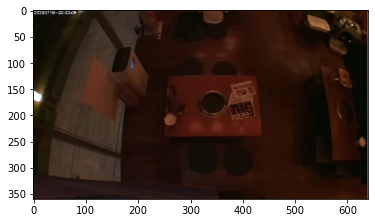

In [5]:
# Example of 0: No one at table
img = plt.imread('frame0.jpg')   
plt.imshow(img)

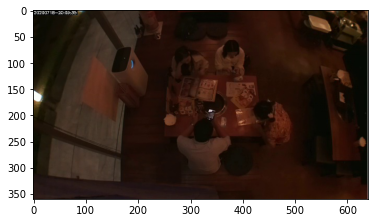

In [6]:
# Example of 1: Customers seated and menu on table (i.e. deciding/ordering)
img = plt.imread('frame386.jpg')   
plt.imshow(img)

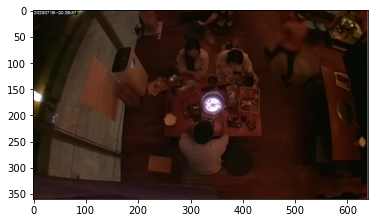

In [7]:
# Example of 2: Customers seated and menu not on table (e.g. eating)
img = plt.imread('frame1550.jpg')   
plt.imshow(img)

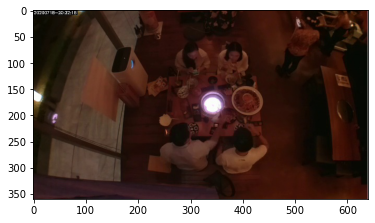

In [8]:
# Example of 3: Customers fully seated (i.e. all customers in table have arrived)
img = plt.imread('frame1749.jpg')   
plt.imshow(img)

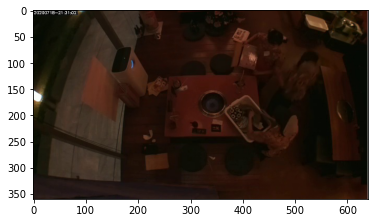

In [9]:
# Example of 4: Customers have left after the meal, table is being cleaned
img = plt.imread('frame5275.jpg')   
plt.imshow(img)

In [10]:
# Create dataframe to store image name and labels 
# (manually label 100 images for each class)
df = pd.DataFrame(columns=['Image','Labels'])
df['Labels'] = [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100

In [11]:
# Manually select and label some images based on the 4 class labels 
# which will be used for model training and validation
class0 = []
for i in range (50):
    class0.append('frame' + str(i) + '.jpg')
for i in range (5772, 5822):
    class0.append('frame' + str(i) + '.jpg')

class1 = []
for i in range (360, 410):
    class1.append('frame' + str(i) + '.jpg')
for i in range (690, 740):
    class1.append('frame' + str(i) + '.jpg')

class2 = []
for i in range (1045, 1095):
    class2.append('frame' + str(i) + '.jpg')
for i in range (1500, 1550):
    class2.append('frame' + str(i) + '.jpg')
    
class3 = []
for i in range (1742, 1775):
    class3.append('frame' + str(i) + '.jpg')
for i in range (3395, 3428):
    class3.append('frame' + str(i) + '.jpg')
for i in range (4490, 4524):
    class3.append('frame' + str(i) + '.jpg')
    
class4 = []
for i in range (5275, 5375):
    class4.append('frame' + str(i) + '.jpg')
    
df['Image'] = class0 + class1 + class2 + class3 + class4
df

,Image,Labels
0,frame0.jpg,0
1,frame1.jpg,0
2,frame2.jpg,0
3,frame3.jpg,0
4,frame4.jpg,0
...,...,...
495,frame5370.jpg,4
496,frame5371.jpg,4
497,frame5372.jpg,4
498,frame5373.jpg,4


In [12]:
# Read labelled images
x = [ ]    
for img_name in df['Image']:
    img = plt.imread('' + img_name)
    x.append(img)  
x = np.array(x) 

In [13]:
# Apply one hot encoding on the 5 class labels
dummy_class = np_utils.to_categorical(df['Labels'])

In [14]:
# Resize images (required as pretrained model VGG16 will be used)
img = []
for i in range(0, x.shape[0]):
    a = resize(x[i], preserve_range=True, output_shape=(224,224)).astype(int) 
    img.append(a)
x = np.array(img)

In [15]:
# Preprocess the images data before modelling
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x, mode='tf')      

In [16]:
# Split data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(x, dummy_class, test_size=0.3, random_state=123)

(c) Train model with pre-trained VGG16 CNN

In [17]:
# Import libraries for modelling 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, InputLayer, Dropout

In [18]:
# Prepare model to extract features from images
extract_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
# Fit model on images data in training and validation set to get features
X_train = extract_model.predict(X_train)
X_valid = extract_model.predict(X_valid)
X_train.shape, X_valid.shape

((350, 7, 7, 512), (150, 7, 7, 512))

In [20]:
# Reshape to 1-dimensional
X_train = X_train.reshape(350, 7*7*512)     
X_valid = X_valid.reshape(150, 7*7*512)

In [21]:
# Center the data about 0
X_train = X_train/X_train.max()     
X_valid = X_valid/X_valid.max()

In [22]:
# Build the VGG16 CNN model 
# 3 hidden and dropout layers
model = Sequential()
model.add(InputLayer((7*7*512,)))    
model.add(Dense(units=1024, activation='sigmoid'))   
model.add(Dropout(0.5))      
model.add(Dense(units=512, activation='sigmoid'))   
model.add(Dropout(0.5))      
model.add(Dense(units=256, activation='sigmoid'))    
model.add(Dropout(0.5))      
model.add(Dense(5, activation='softmax')) # 5 classes       

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1

In [24]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# Fit the model on training data and evaluate accuracy on validation data
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

## Accuracy on validation set is high, could be because training and validation set data are relatively similar in this case

Epoch 1/100
11/11 [==============================] - 2s 190ms/step - loss: 1.8897 - accuracy: 0.1514 - val_loss: 1.5617 - val_accuracy: 0.2200
Epoch 2/100
11/11 [==============================] - 1s 130ms/step - loss: 1.7282 - accuracy: 0.2457 - val_loss: 1.5368 - val_accuracy: 0.3667
Epoch 3/100
11/11 [==============================] - 1s 129ms/step - loss: 1.6201 - accuracy: 0.2800 - val_loss: 1.3369 - val_accuracy: 1.0000
Epoch 4/100
11/11 [==============================] - 1s 130ms/step - loss: 1.3691 - accuracy: 0.4257 - val_loss: 1.0333 - val_accuracy: 0.8000
Epoch 5/100
11/11 [==============================] - 1s 129ms/step - loss: 1.0078 - accuracy: 0.5771 - val_loss: 0.7100 - val_accuracy: 1.0000
Epoch 6/100
11/11 [==============================] - 1s 131ms/step - loss: 0.7325 - accuracy: 0.7143 - val_loss: 0.4563 - val_accuracy: 1.0000
Epoch 7/100
11/11 [==============================] - 1s 130ms/step - loss: 0.5197 - accuracy: 0.8457 - val_loss: 0.2575 - val_accuracy: 1.0000

(d) Use fitted model to make predictions on full video

In [26]:
# Read all images from the full video
imgnames = []
for i in range(5822):
    imgnames.append('frame' + str(i) + '.jpg')

full_vid = [ ]    
for img_name in imgnames:
    img = plt.imread('' + img_name)
    full_vid.append(img)  
full_vid = np.array(full_vid) 

In [27]:
# Resize all images from the full video
full_img = []
for i in range(0, full_vid.shape[0]):
    a = resize(full_vid[i], preserve_range=True, output_shape=(224,224)).astype(int) 
    full_img.append(a)
full_img = np.array(full_img)

In [28]:
# Preprocess the images
full_img = preprocess_input(full_img, mode='tf')

# Extract features from the images
full_img = extract_model.predict(full_img)
full_img.shape

(5822, 7, 7, 512)

In [29]:
# Convert the images to 1-D
full_img = full_img.reshape(5822, 7*7*512)

# Center images data around 0
full_img = full_img/full_img.max()

In [33]:
# Obtain predictions of the 5 classes from fitted model
predictions = model.predict_classes(full_img)

In [35]:
# Obtain predicted duration of each class in the full video
print("Predictions from video_sample1:")
print("0: No one is at the table - ", round(predictions[predictions==0].shape[0]/60, 2), "minutes")
print("1: Customers are seated and the menu is on the table (i.e. deciding/ordering) - ", round(predictions[predictions==1].shape[0]/60, 2), "minutes")
print("2: Customers are seated and the menu is not on the table (e.g. eating) - ", round(predictions[predictions==2].shape[0]/60, 2), "minutes")
print("3: Customers are fully seated (i.e. all customers in the table have arrived) - ", round(predictions[predictions==3].shape[0]/60, 2), "minutes")
print("4: Customers have left after the meal, table is being cleaned - ", round(predictions[predictions==4].shape[0]/60, 2), "minutes")

print("----------------")
print("Total estimated time taken for customers to order = ", round(predictions[predictions==1].shape[0]/60, 2), "minutes")

Predictions from video_sample1:
0: No one is at the table -  12.58 minutes
1: Customers are seated and the menu is on the table (i.e. deciding/ordering) -  11.62 minutes
2: Customers are seated and the menu is not on the table (e.g. eating) -  10.55 minutes
3: Customers are fully seated (i.e. all customers in the table have arrived) -  58.13 minutes
4: Customers have left after the meal, table is being cleaned -  4.15 minutes
----------------
Total estimated time taken for customers to order =  11.62 minutes


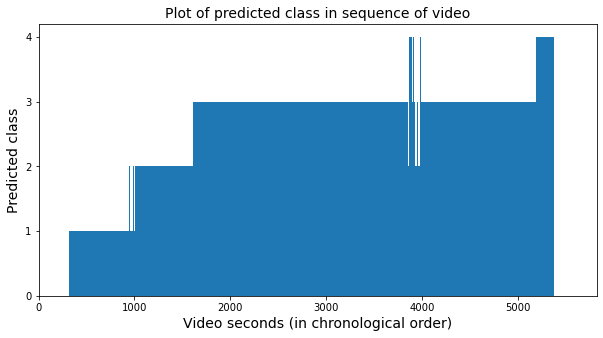

In [38]:
# Visualize prediction results
dfpred=pd.DataFrame(predictions, columns=['y_pred'])
plt.figure(figsize=(10,5))
plt.bar(dfpred.index,dfpred['y_pred'], width = 1)
plt.title('Plot of predicted class in sequence of video', size=14)
plt.xlabel('Video seconds (in chronological order)', size=14)
plt.ylabel('Predicted class',size=14)
plt.xlim((0,5821))
plt.yticks(np.arange(0, 5, 1))
plt.show()